# Camera to Observer Mapping

An exploratory notebook about mapping camera sensitivities to a particular observer.

More information is available on [ACEScentral](https://acescentral.com/c/aces-development-acesnext/vwg-aces-gamut-mapping-working-group/) and [colour-science.discourse.group](https://colour-science.discourse.group/t/camera-to-observer-mapping-exploration/)

*TODO*:

* Add basic 3x3 linear mapping
* Test normalisation of CMFS as suggested by Harald
* Use AMPAS training data
* Implement support for LUT export
* Investigate data normalisation process via absolute luminance scaling: None of the methods is exposure invariant, note that Finlayson (2015) with Root Polynomials should be.
* Explore blend with regular IDT based on Pointer's Gamut boundaries


## colour-science Requirements

In [0]:
!pip install colour-datasets
!pip install pandas
!pip install plotly

!pip uninstall -y colour-science
!if ! [ -d "colour" ]; then git clone https://github.com/colour-science/colour; fi
!if [ -d "colour" ]; then cd colour && git fetch && git checkout develop && git pull && cd ..; fi

import sys
sys.path.append('colour')

  Using cached https://files.pythonhosted.org/packages/2e/b8/a25564da5f41a2d349afb3e95f8c5d7007231450bacf433a92301b073070/colour_science-0.3.15-py2.py3-none-any.whl
Uninstalling colour-science-0.3.15:
  Successfully uninstalled colour-science-0.3.15
Already on 'develop'
Your branch is up to date with 'origin/develop'.
Already up to date.


In [0]:
import colour
import colour_datasets
import colour.plotting
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tqdm
from scipy.interpolate import LinearNDInterpolator
from plotly.graph_objects import Figure, Mesh3d, Scatter3d

colour.plotting.colour_style()

plt.style.use({'figure.figsize': (12.80, 7.20)})

colour.utilities.describe_environment();

*                                                                             *
*   Interpreter :                                                             *
*       python : 3.6.9 (default, Nov  7 2019, 10:44:02)                       *
*                [GCC 8.3.0]                                                  *
*                                                                             *
*   colour-science.org :                                                      *
*       colour : v0.3.15-62-g50a40abf                                         *
*       colour-datasets : 0.1.0                                               *
*                                                                             *
*   Runtime :                                                                 *
*       imageio : 2.4.1                                                       *
*       matplotlib : 3.2.1                                                    *
*       networkx : 2.4                  

## Cameras Sensitivites Datasets

In [0]:
print(colour_datasets.datasets())

colour-science-datasets

Datasets : 16
Synced   : 2
URL      : https://zenodo.org/communities/colour-science-datasets/

Datasets
--------

[ ] 3269926 : Agfa IT8.7/2 Set
[x] 3245883 : Camera Spectral Sensitivity Database
[ ] 3367463 : Constant Hue Loci Data
[ ] 3362536 : Constant Perceived-Hue Data
[ ] 3270903 : Corresponding-Colour Datasets
[ ] 3269920 : Forest Colors
[ ] 3245875 : Labsphere SRS-99-020
[ ] 3269924 : Lumber Spectra
[ ] 3269918 : Munsell Colors Glossy (All) (Spectrofotometer Measured)
[ ] 3269916 : Munsell Colors Glossy (Spectrofotometer Measured)
[ ] 3269914 : Munsell Colors Matt (AOTF Measured)
[ ] 3269912 : Munsell Colors Matt (Spectrofotometer Measured)
[ ] 3245895 : New Color Specifications for ColorChecker SG and Classic Charts
[ ] 3252742 : Observer Function Database
[ ] 3269922 : Paper Spectra
[x] 3372171 : RAW to ACES Utility Data


In [0]:
CAMERA_SENSITIVITIES_DATABASE = colour_datasets.load(
    'Camera Spectral Sensitivity Database')
AMPAS_CAMERA_SENSITIVITIES_DATABASE = colour_datasets.load(
    'RAW to ACES Utility Data')

CAMERA_SENSITIVITIES_DATABASE.keys()

odict_keys(['Canon 1DMarkIII', 'Canon 20D', 'Canon 300D', 'Canon 40D', 'Canon 500D', 'Canon 50D', 'Canon 5DMarkII', 'Canon 600D', 'Canon 60D', 'Hasselblad H2', 'Nikon D3X', 'Nikon D200', 'Nikon D3', 'Nikon D300s', 'Nikon D40', 'Nikon D50', 'Nikon D5100', 'Nikon D700', 'Nikon D80', 'Nikon D90', 'Nokia N900', 'Olympus E-PL2', 'Pentax K-5', 'Pentax Q', 'Point Grey Grasshopper 50S5C', 'Point Grey Grasshopper2 14S5C', 'Phase One', 'SONY NEX-5N'])

## Observer & Camera Definitions

The observer and camera sensitivities of interest.

"CIE 1931 2 Degree Standard Observer": [ 0.99847889  1.          0.9970675 ]
"Hasselblad H2": [ 0.3939756   1.          1.00023554]


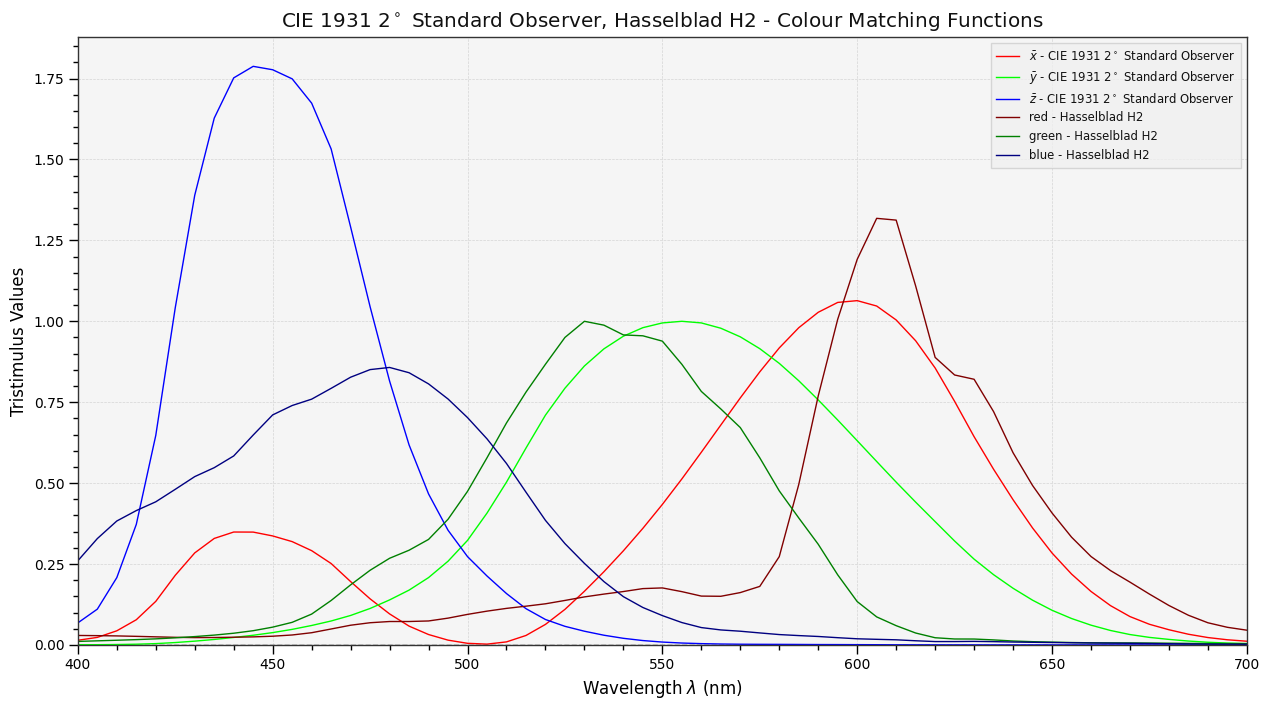

In [0]:
INTERVAL = 5  # Spectral bin size.

SHAPE = colour.SpectralShape(400, 700, INTERVAL)
WAVELENGTHS = SHAPE.range()


def normalise_multi_signal(multi_signal):
    multi_signal = multi_signal.copy()

    f_n = colour.sd_to_XYZ(colour.sd_ones(), cmfs=multi_signal) / 100
    print('"{0}": {1}'.format(multi_signal.name, f_n))
    multi_signal.values = multi_signal.values / f_n

    return multi_signal


CMFS_1_NAME = 'CIE 1931 2 Degree Standard Observer'
CMFS_1 = normalise_multi_signal(colour.CMFS[CMFS_1_NAME].copy().align(SHAPE))

# CMFS_2_NAME = 'CIE 2012 2 Degree Standard Observer'
# CMFS_2 = colour.CMFS[CMFS_2_NAME].copy().align(shape)

CMFS_2_NAME = 'Hasselblad H2'
CMFS_2 = normalise_multi_signal(
    CAMERA_SENSITIVITIES_DATABASE[CMFS_2_NAME].copy().align(SHAPE))

colour.plotting.plot_multi_cmfs([CMFS_1, CMFS_2]);

## Spectral Distributions

Generation of two sets spectral reflectance distributions:

- Outer Visible Spectrum Surface: Generated using square pulses of varying bandwidth.
- Inner 3D Grid: Generated using Meng et al. (2015) Reflectance Recovery method.

In [0]:
MSDS_OUTER = colour.volume.generate_pulse_waves(len(WAVELENGTHS))
XYZ_OUTER = colour.volume.XYZ_outer_surface(CMFS_1)

# XYZ_INNER = np.random.rand(5000, 3)
# XYZ_INNER = XYZ_inner[colour.is_within_visible_spectrum(XYZ_inner, CMFS_1)]

GRID_SAMPLES = 10  # Samples along axis of the Inner 3D Grid.

TABLE = colour.LUT3D.linear_table(GRID_SAMPLES).reshape(-1, 3)
XYZ_INNER = TABLE[colour.is_within_visible_spectrum(TABLE, CMFS_1)]


def XYZ_to_sd_wrapper(XYZ):
    """
    Multiprocessing helper definition.
    """

    return colour.XYZ_to_sd(
        XYZ, cmfs=CMFS_1, optimisation_parameters={'options': {
            'ftol': 1e-5
        }})


with colour.utilities.multiprocessing_pool() as pool:
    MSDS_INNER = [
        sd.values
        for sd in tqdm.tqdm(pool.imap_unordered(XYZ_to_sd_wrapper, XYZ_INNER),
                            total=XYZ_INNER.shape[0])
    ]

MSDS_INNER = np.vstack(MSDS_INNER)

MSDS = np.vstack([MSDS_OUTER, MSDS_INNER])

len(MSDS_OUTER), len(MSDS_INNER)

100%|██████████| 276/276 [08:46<00:00,  1.91s/it]


(3662, 276)

## ColorChecker Classic Data

The ColorChecker classic data is used here as an example training set. Alternatively, the ColorChecker SG or another 3D grid with different spacing could/should be used.

colour/colour/utilities/verbose.py:235: ColourUsageWarning:

"colour.COLOURCHECKERS_SDS" object has been renamed to "colour.COLOURCHECKER_SDS".



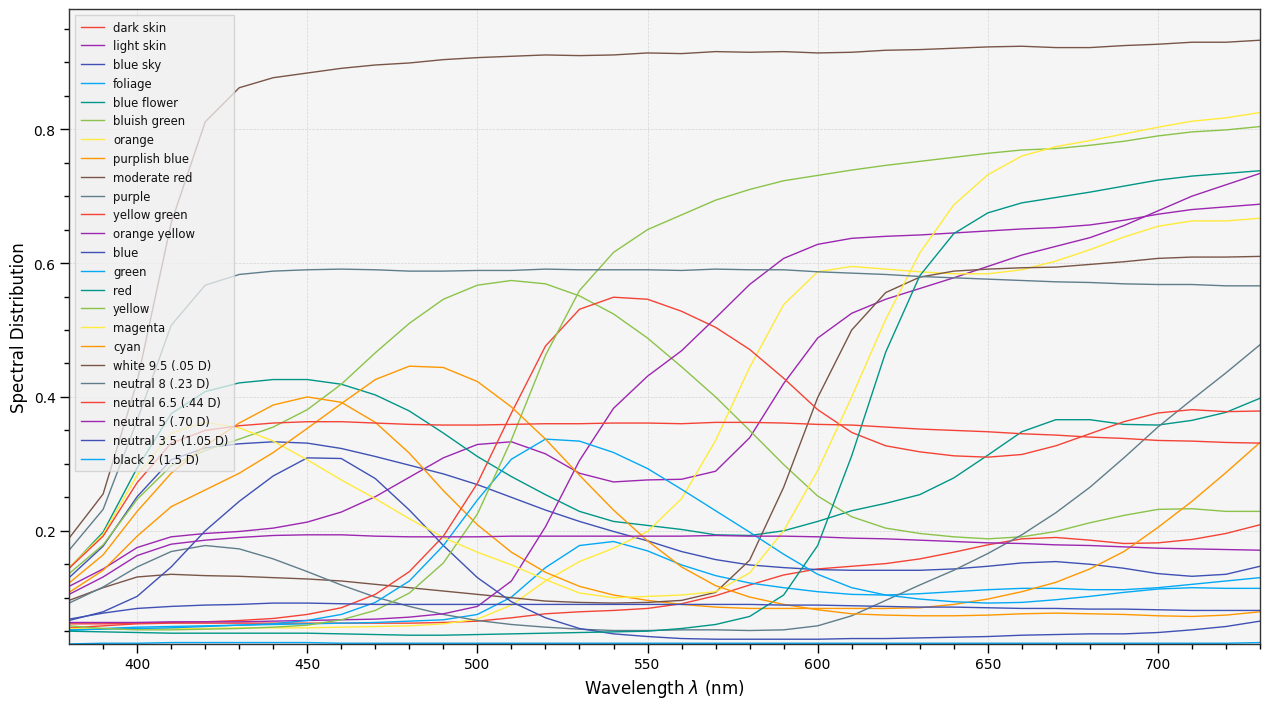

In [0]:
COLORCHECKER_CLASSIC_SDS = list(
    colour.COLOURCHECKERS_SDS['BabelColor Average'].values())

colour.plotting.plot_multi_sds(COLORCHECKER_CLASSIC_SDS);

The tristimulus values of the ColorChecker Classic under the observer and camera of interest.

In [0]:
MSDS_CC = colour.utilities.as_float_array(
    [sd.copy().align(SHAPE).values for sd in COLORCHECKER_CLASSIC_SDS]
)

XYZ_1_CC = colour.multi_sds_to_XYZ(
    MSDS_CC, method='Integration', cmfs=CMFS_1, shape=SHAPE) / 100

XYZ_2_CC =colour.multi_sds_to_XYZ(
    MSDS_CC, method='Integration', cmfs=CMFS_2, shape=SHAPE) / 100

## Tristimulus Values

The tristimulus values of spectral reflectance distributions used to compute the mapping under the observer and camera of interest.

In [0]:
XYZ_1 = colour.multi_sds_to_XYZ(
    MSDS, method='Integration', cmfs=CMFS_1, shape=SHAPE) / 100
# MASK_1 = np.where(colour.is_within_visible_spectrum(XYZ_1, CMFS_1))[0]

XYZ_2 = colour.multi_sds_to_XYZ(
    MSDS, method='Integration', cmfs=CMFS_2, shape=SHAPE) / 100
# MASK_2 = np.where(colour.is_within_visible_spectrum(XYZ_2, CMFS_2))[0]

# MASK = np.intersect1d(MASK_1, MASK_2)

# XYZ_1 = XYZ_1[MASK, ...]
# XYZ_2 = XYZ_2[MASK, ...]

PM_METHOD_NAME = 'Polynomial Mapping'


def polynomial_mapping(a, terms=7):
    offset = np.mean(XYZ_1, axis=0) - np.mean(XYZ_2, axis=0)

    return colour.colour_correction(a + offset,
                                    XYZ_2 + offset,
                                    XYZ_1,
                                    terms=terms)


NM_METHOD_NAME = 'Linear Barycentric Mapping'


def nd_mapping(a):
    return LinearNDInterpolator(XYZ_2, XYZ_1)(a)

Reference data in CIE XYZ colourspace.

In [0]:
XYZ_2_PM = polynomial_mapping(XYZ_2)
XYZ_2_NM = nd_mapping(XYZ_2)

XYZ_2_CC_PM = polynomial_mapping(XYZ_2_CC)
XYZ_2_CC_NM = nd_mapping(XYZ_2_CC)

MARKER_STYLE = dict(size=3, opacity=0.5)
PLOT_DATA = [
    Scatter3d(x=[0, 1],
              y=[0, 1],
              z=[0, 1],
              mode='markers',
              marker=MARKER_STYLE,
              name='Anchors')
]

# Reference Data
if True:
    PLOT_DATA += [
        Scatter3d(x=XYZ_OUTER[..., 0],
                  y=XYZ_OUTER[..., 2],
                  z=XYZ_OUTER[..., 1],
                  mode='markers',
                  marker=MARKER_STYLE,
                  name='Reference - XYZ Outer'),
        Scatter3d(x=XYZ_INNER[..., 0],
                  y=XYZ_INNER[..., 2],
                  z=XYZ_INNER[..., 1],
                  mode='markers',
                  marker=MARKER_STYLE,
                  name='Reference - XYZ Inner'),
        Scatter3d(x=XYZ_1[..., 0],
                  y=XYZ_1[..., 2],
                  z=XYZ_1[..., 1],
                  mode='markers',
                  marker=MARKER_STYLE,
                  name='Recovered - {0}'.format(CMFS_1_NAME)),
        Scatter3d(x=XYZ_2[..., 0],
                  y=XYZ_2[..., 2],
                  z=XYZ_2[..., 1],
                  mode='markers',
                  marker=MARKER_STYLE,
                  name='Recovered - {0}'.format(CMFS_2_NAME)),
        Scatter3d(x=XYZ_2_PM[..., 0],
                  y=XYZ_2_PM[..., 2],
                  z=XYZ_2_PM[..., 1],
                  mode='markers',
                  marker=MARKER_STYLE,
                  name='{0} - {1}'.format(PM_METHOD_NAME, CMFS_2_NAME)),
        Scatter3d(x=XYZ_2_NM[..., 0],
                  y=XYZ_2_NM[..., 2],
                  z=XYZ_2_NM[..., 1],
                  mode='markers',
                  marker=MARKER_STYLE,
                  name='{0} - {1}'.format(NM_METHOD_NAME, CMFS_2_NAME)),
        Scatter3d(x=XYZ_1_CC[..., 0],
                  y=XYZ_1_CC[..., 2],
                  z=XYZ_1_CC[..., 1],
                  mode='markers',
                  marker=MARKER_STYLE,
                  name='ColorChecker - {0}'.format(CMFS_1_NAME)),
        Scatter3d(x=XYZ_2_CC[..., 0],
                  y=XYZ_2_CC[..., 2],
                  z=XYZ_2_CC[..., 1],
                  mode='markers',
                  marker=MARKER_STYLE,
                  name='ColorChecker - {0}'.format(CMFS_2_NAME)),
        Scatter3d(x=XYZ_2_CC_PM[..., 0],
                  y=XYZ_2_CC_PM[..., 2],
                  z=XYZ_2_CC_PM[..., 1],
                  mode='markers',
                  marker=MARKER_STYLE,
                  name='ColorChecker - {0}'.format(PM_METHOD_NAME)),
        Scatter3d(x=XYZ_2_CC_NM[..., 0],
                  y=XYZ_2_CC_NM[..., 2],
                  z=XYZ_2_CC_NM[..., 1],
                  mode='markers',
                  marker=MARKER_STYLE,
                  name='ColorChecker - {0}'.format(NM_METHOD_NAME)),
    ]

# ND Mapping Simplices
if False:
    SIMPLICES = LinearNDInterpolator(XYZ_2, XYZ_1).tri.simplices
    SIMPLICES_STEPS = 100

    PLOT_DATA += [
        Mesh3d(x=XYZ_2[..., 0],
               y=XYZ_2[..., 2],
               z=XYZ_2[..., 1],
               i=SIMPLICES[..., 0][::SIMPLICES_STEPS],
               j=SIMPLICES[..., 2][::SIMPLICES_STEPS],
               k=SIMPLICES[..., 1][::SIMPLICES_STEPS],
               opacity=0.35),
        Mesh3d(x=XYZ_1[..., 0],
               y=XYZ_1[..., 2],
               z=XYZ_1[..., 1],
               i=SIMPLICES[..., 0][::SIMPLICES_STEPS],
               j=SIMPLICES[..., 2][::SIMPLICES_STEPS],
               k=SIMPLICES[..., 1][::SIMPLICES_STEPS],
               opacity=0.35),
    ]

if True:
    MARKER_STYLE = dict(size=1, opacity=0.25, color='#F44336')
    LINE_STYLE = dict(width=2)
    _I = len(MSDS_OUTER)
    for i in range(0, len(MSDS_INNER), 1):
        PLOT_DATA.append(
            Scatter3d(x=[XYZ_1[_I + i, 0], XYZ_2[_I + i, 0]],
                      y=[XYZ_1[_I + i, 2], XYZ_2[_I + i, 2]],
                      z=[XYZ_1[_I + i, 1], XYZ_2[_I + i, 1]],
                      marker=MARKER_STYLE,
                      line=LINE_STYLE,
                      name='R--> {0}'.format(i + 1)))

if True:
    MARKER_STYLE = dict(size=1, opacity=0.25, color='#3F51B5')
    LINE_STYLE = dict(width=3)
    for i in range(XYZ_1_CC.shape[0]):
        PLOT_DATA.append(
            Scatter3d(x=[XYZ_2_CC[i, 0], XYZ_2_CC_PM[i, 0]],
                      y=[XYZ_2_CC[i, 2], XYZ_2_CC_PM[i, 2]],
                      z=[XYZ_2_CC[i, 1], XYZ_2_CC_PM[i, 1]],
                      marker=MARKER_STYLE,
                      line=LINE_STYLE,
                      name='PM--> {0}'.format(i + 1)))

if True:
    MARKER_STYLE = dict(size=1, opacity=0.25, color='#B53F51')
    LINE_STYLE = dict(width=3)
    for i in range(XYZ_1_CC.shape[0]):
        PLOT_DATA.append(
            Scatter3d(x=[XYZ_2_CC[i, 0], XYZ_2_CC_NM[i, 0]],
                      y=[XYZ_2_CC[i, 2], XYZ_2_CC_NM[i, 2]],
                      z=[XYZ_2_CC[i, 1], XYZ_2_CC_NM[i, 1]],
                      marker=MARKER_STYLE,
                      line=LINE_STYLE,
                      name='NM--> {0}'.format(i + 1)))

if True:
    MARKER_STYLE = dict(size=1, opacity=0.5, color='#009688')
    LINE_STYLE = dict(width=5)
    for i in range(XYZ_1_CC.shape[0]):
        PLOT_DATA.append(
            Scatter3d(x=[XYZ_2_CC[i, 0], XYZ_1_CC[i, 0]],
                      y=[XYZ_2_CC[i, 2], XYZ_1_CC[i, 2]],
                      z=[XYZ_2_CC[i, 1], XYZ_1_CC[i, 1]],
                      marker=MARKER_STYLE,
                      line=LINE_STYLE,
                      name='G--> {0}'.format(i + 1)))

FIGURE = Figure(PLOT_DATA)

FIGURE.update_layout(width=1280, height=720)

FIGURE.show()

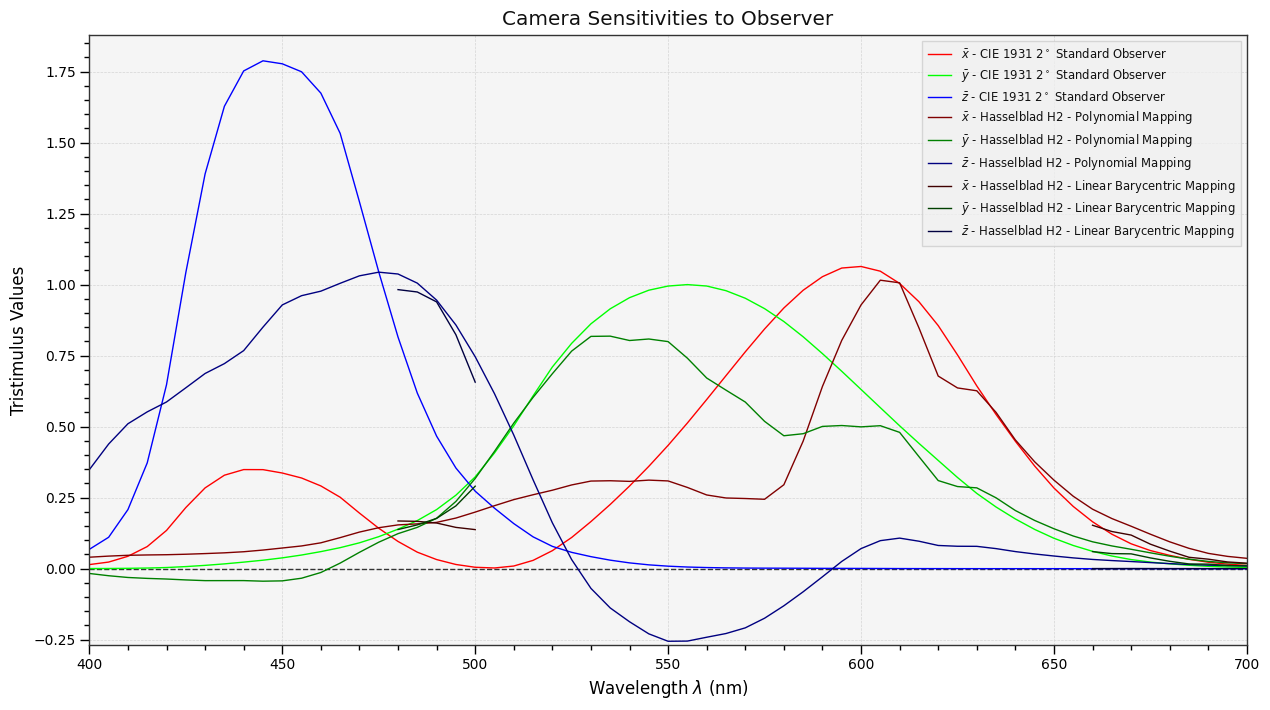

In [0]:
CMFS_2_PM = colour.colorimetry.XYZ_ColourMatchingFunctions(
    polynomial_mapping(CMFS_2.values),
    WAVELENGTHS,
    name='{0} - {1}'.format(CMFS_2_NAME, PM_METHOD_NAME))

# TODO: Should match perfectly, might blowing up because values are slightly out
# of Delaunay hull.
CMFS_2_NM = colour.colorimetry.XYZ_ColourMatchingFunctions(
    nd_mapping(CMFS_2.values),
    WAVELENGTHS,
    name='{0} - {1}'.format(CMFS_2_NAME, NM_METHOD_NAME))

colour.plotting.plot_multi_cmfs([CMFS_1, CMFS_2_PM, CMFS_2_NM],
                                title='Camera Sensitivities to Observer');

## Plots & Statistics

In [0]:
def plot_observers_mapping(xy_1, xy_2, xy_3, **kwargs):
    figure, axes = colour.plotting.diagrams.plot_spectral_locus(
        cmfs=CMFS_1, standalone=False, spectral_locus_colours='#03A9F4')

    axes.plot(xy_1[..., 0], xy_1[..., 1], 'o', label='Mapped')
    axes.plot(xy_2[..., 0], xy_2[..., 1], 'x', label='Reference')
    axes.plot(xy_3[..., 0], xy_3[..., 1], '^', label='Original')

    axes.quiver(xy_1[..., 0], xy_1[..., 1],
                xy_2[..., 0] - xy_1[..., 0], xy_2[..., 1] - xy_1[..., 1],
                color='#607D8B', angles='xy', scale_units='xy', scale=1,
                width=0.001)

    settings = {'standalone': True, 'legend': True}
    settings.update(kwargs)

    colour.plotting.render(**settings)

colour/colour/algebra/geometry.py:79: RuntimeWarning:

invalid value encountered in true_divide

posx and posy should be finite values
posx and posy should be finite values


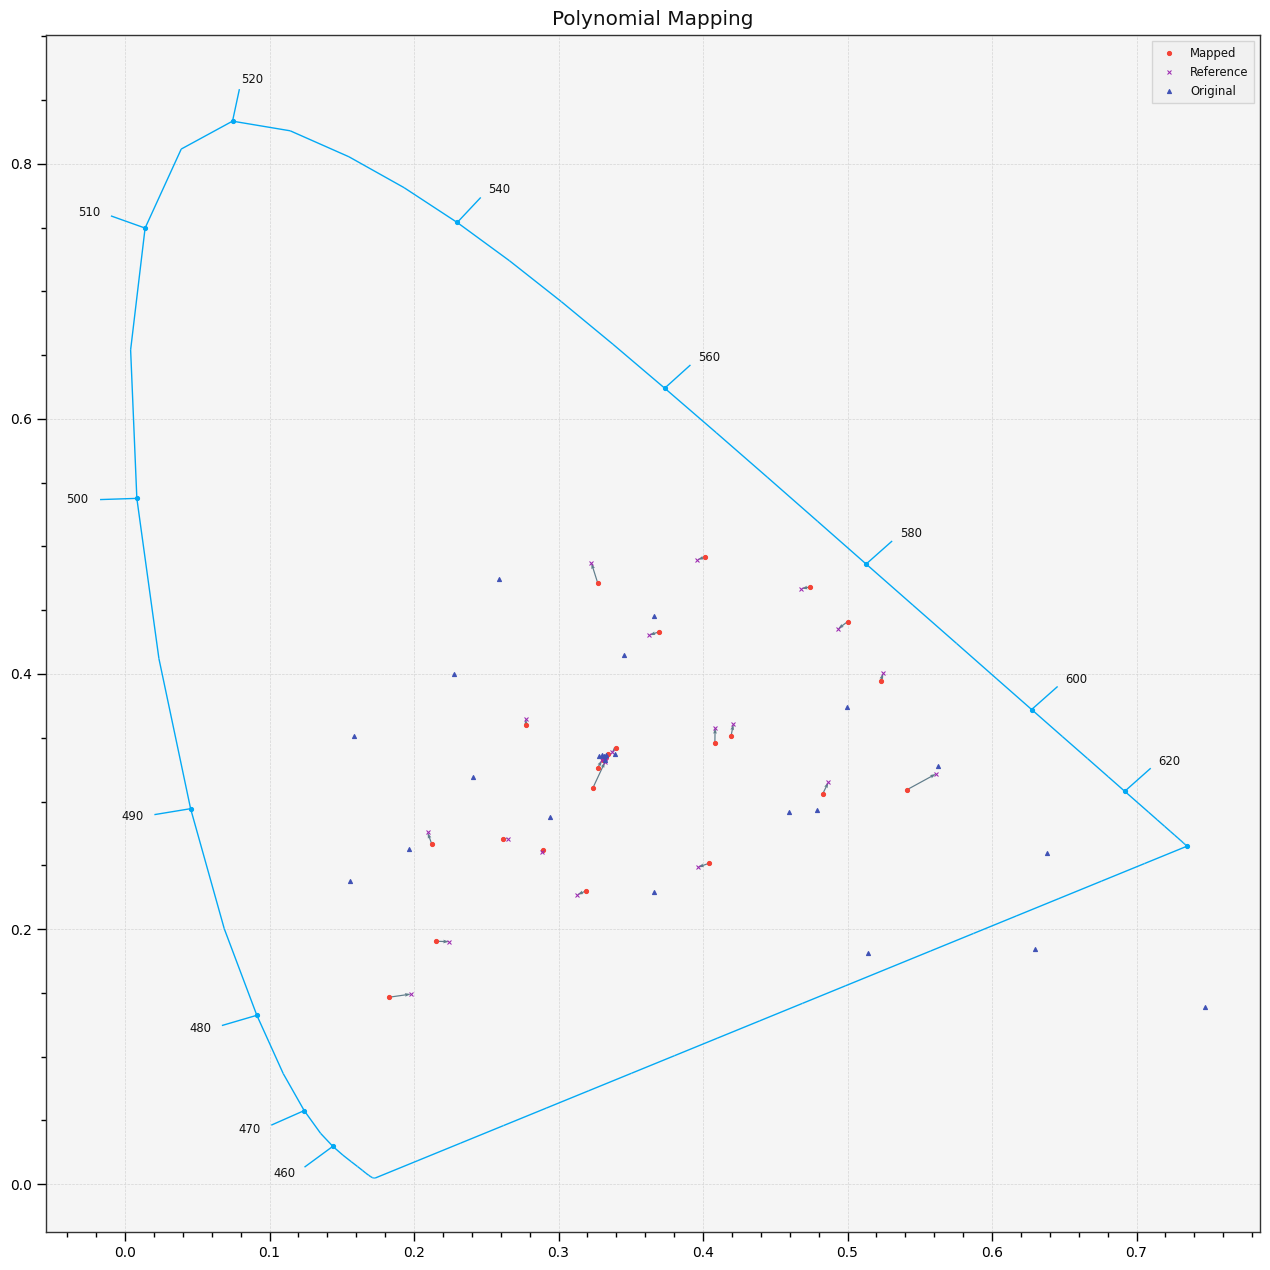

colour/colour/algebra/geometry.py:79: RuntimeWarning:

invalid value encountered in true_divide

posx and posy should be finite values
posx and posy should be finite values


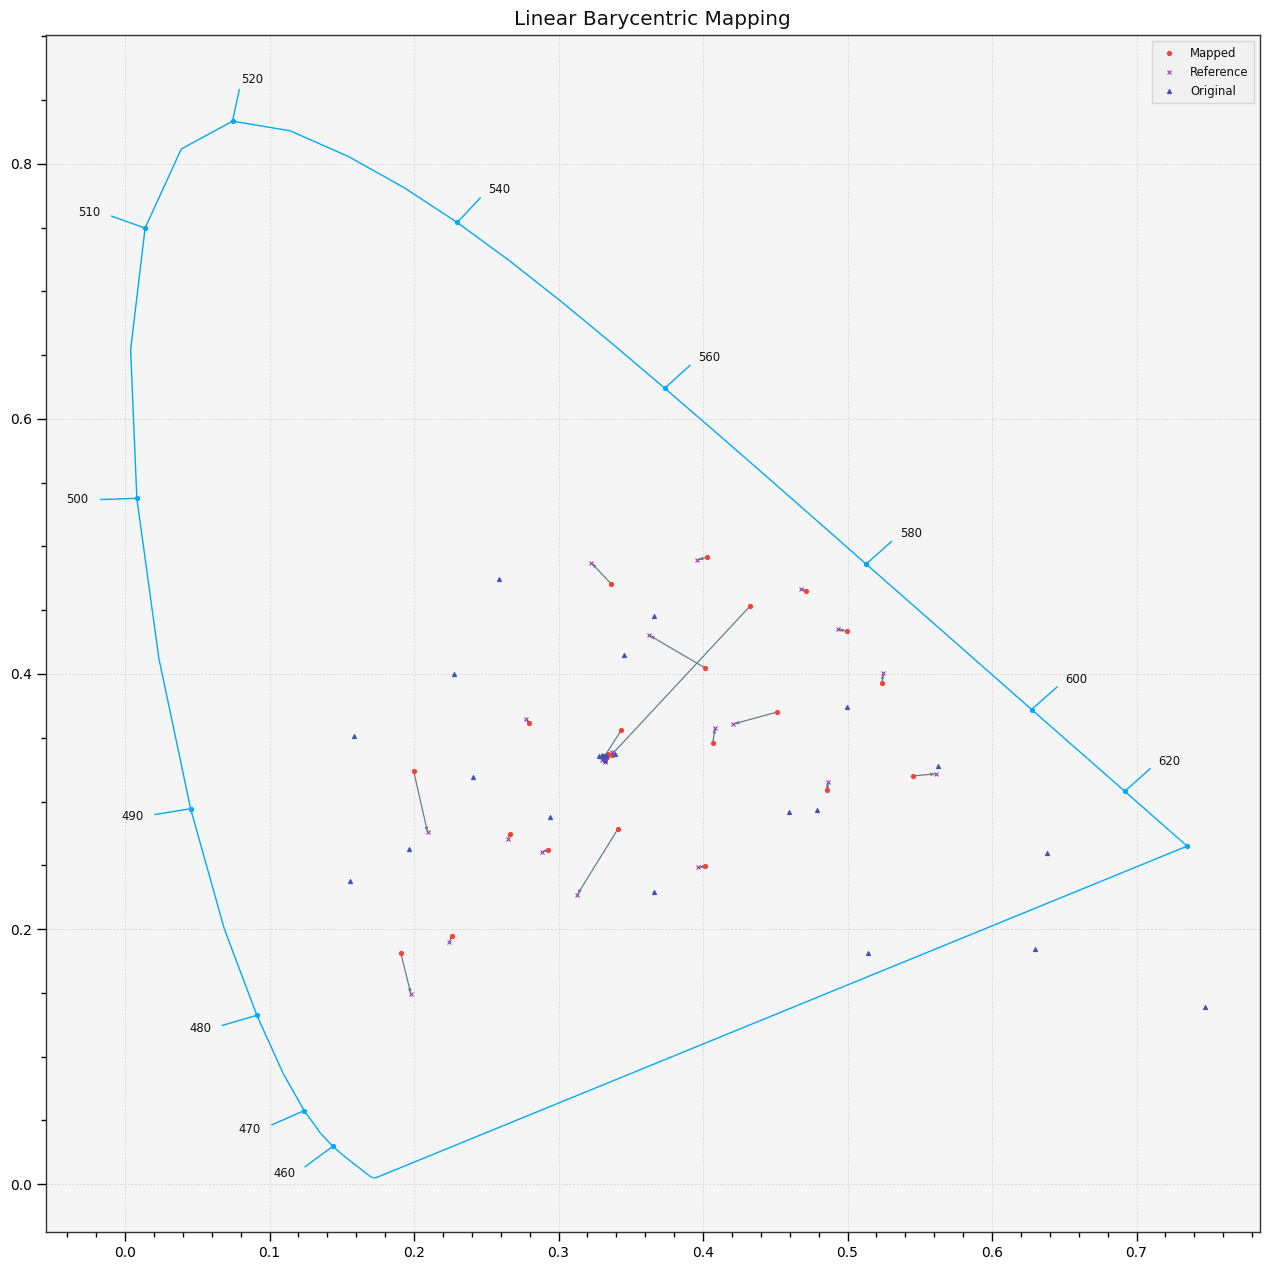

In [0]:
XY_2 = colour.XYZ_to_xy(XYZ_1_CC)  # 'x'
XY_3 = colour.XYZ_to_xy(XYZ_2_CC)  # '^'

plot_observers_mapping(
    colour.XYZ_to_xy(XYZ_2_CC_PM),
    XY_2, XY_3, title=PM_METHOD_NAME)

plot_observers_mapping(
    colour.XYZ_to_xy(XYZ_2_CC_NM),
    XY_2, XY_3, title=NM_METHOD_NAME)

In [0]:
PM_SERIES = pd.Series(colour.algebra.euclidean_distance(XYZ_1_CC, XYZ_2_CC_PM),
                      name=PM_METHOD_NAME)

print(PM_SERIES.describe())

print('*' * 79)

NM_SERIES = pd.Series(colour.algebra.euclidean_distance(XYZ_1_CC, XYZ_2_CC_NM),
                      name=NM_METHOD_NAME)

print(NM_SERIES.describe())

count    24.000000
mean      0.018363
std       0.016192
min       0.001534
25%       0.004788
50%       0.015062
75%       0.022782
max       0.059788
Name: Polynomial Mapping, dtype: float64
*******************************************************************************
count    24.000000
mean      0.030181
std       0.023401
min       0.002191
25%       0.013184
50%       0.024104
75%       0.041929
max       0.098906
Name: Linear Barycentric Mapping, dtype: float64
